# Imports

In [ ]:
import numpy as np
from numpy import random
import tensorflow as tf
from tensorflow import keras, concat
from keras.layers import Conv1D, Conv1DTranspose, Lambda, Input, Bidirectional, LSTM, Dense, UpSampling1D, Concatenate, ZeroPadding1D
from keras.activations import sigmoid, relu

import librosa
import scipy

# Custom Model Components

## Custom Layers

### GLU (Gated Linear Unit) Layer

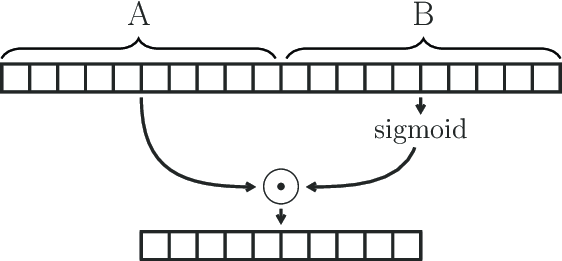

The GLU is essentially a sequence of three functions: a linear transformation, a sigmoid function, and a matrix product. We implement this in keras below.

This activation function does the following:

- Splits its input matrix into two matrices
- Applies an identity (or linear) transformation to one half
  - For the sake of simplicity, I've gone with an identity transformation
- Applies a sigmoid function to the other half
- Returns the element-wise product of these two new matrices

Given the nature of gradient descent and back propagation, this will ultimately allow our learning algorithm to use the sigmoid function as a mask, or a gating function.
- The values uphill of the sigmoid function will, in time, learn to return values closer to zero to where factors correspond to irrelevant features and noise. 

Note that this behaviour that will have to be learned by the learning algorithm...which is pretty cool! We're basically dropping a functional architecture into the model and hoping it learns how to use it!

In [ ]:
class gokaf_glu(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()
    pass


  def call(self, inputs):
    # split the inputs into two groups, then  assign variables for both groups
    these_puts = tf.split(inputs,2,axis=2)
    lin_puts = these_puts[0]
    sig_puts = sigmoid(these_puts[1])
    # get the matrix sum of these groups and return it
    outputs = tf.math.multiply(lin_puts,sig_puts)
    return outputs

### Pad / Concatenation Layer

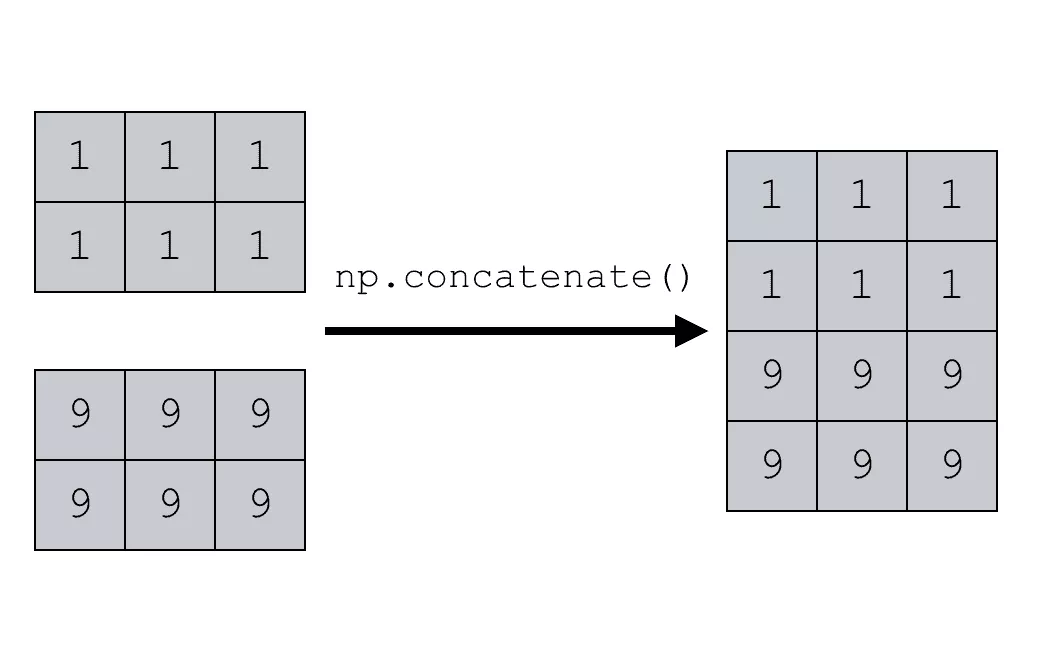

Combining skips with deconvolution/transpose convolution layers will lead to some problems; we will often run into problems matching the dimensions of the tensors we are trying to concatenate.

This function pads two tensors to the size of the larger of them, and then returns them packed into a concatenation layer. Easy peasy!

In [ ]:
class gokaf_padcat(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(gokaf_padcat, self).__init__(**kwargs)
    self.concat_layer = Concatenate(axis=-1)

  def call(self, inputs):
      # get input shapes
    size1 = tf.shape(inputs[0])[1]
    size2 = tf.shape(inputs[1])[1]

    # get maximum size
    max_size = tf.maximum(size1, size2)

    # get require padding
    padding1 = max_size - size1
    padding2 = max_size - size2

    # pad both tensors, exhaustively because we're lazy
    padded1 = tf.pad(inputs[0], [[0, 0], [0, padding1], [0, 0]])
    padded2 = tf.pad(inputs[1], [[0, 0], [0, padding2], [0, 0]])

    # concatenate & return them
    result = self.concat_layer([padded1, padded2])
    return result

# Model Building Functions

## Encoder Components

### Encoder Convolution Layers, Encoder Block

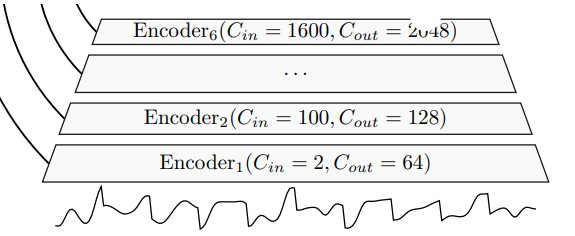

In [ ]:
# the first encoder layer, with relu activation
def inenc_conv1(num_filters,
                prev_out,
                k_s=8,
                s_s=4,
                act='relu',
                padding='valid',
                is_first=False):
  # double outputs each time, then set the convolution layer 
  num_filters = num_filters*2 if not is_first else num_filters
  this_conv1 = Conv1D(filters=num_filters, 
                      kernel_size=k_s, 
                      padding=padding,
                      strides=s_s, 
                      activation=act)(prev_out)
  return this_conv1, num_filters

# the second encoder layer. We set no activation here because we implement GLU
# (cont.) as its own layer - functionally it's the same
def inenc_conv2(num_filters,
                prev_conv,
                k_s=1, 
                s_s=1, 
                padding='valid',
                is_first=False,
                act=None):
  # double input for outputs, but this value will be halved by the GLU
  num_filters = num_filters*2
  this_conv2 = Conv1D(filters=num_filters, 
                      kernel_size=k_s,
                      padding=padding,
                      strides=s_s, 
                      activation=act)(prev_conv)
  return this_conv2, num_filters

# create a block - two layers with a GLU filter after the second one
# we return half the number of filters because that value is doubled in conv2,
# but not halved in gokaf_glu
def encoder_block(prev_out, num_filters, is_first=False):
  conv1, num_filters = inenc_conv1(is_first=is_first, 
                      num_filters=num_filters, 
                      prev_out=prev_out)
  conv2, num_filters = inenc_conv2(is_first=is_first,
                      num_filters=num_filters,
                      prev_conv=conv1)
  this_glu = gokaf_glu()(inputs=conv2)
  return this_glu, num_filters//2


## Decoder Components

### Decoder Convolution Layers, Decoder Block

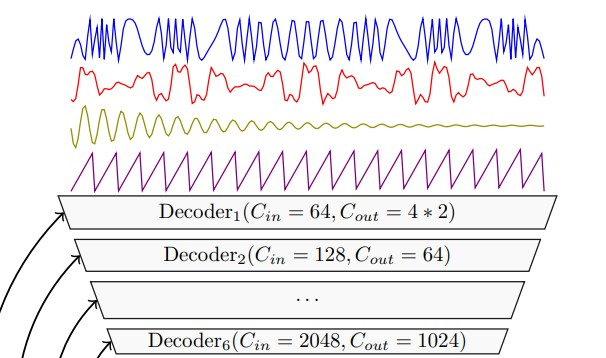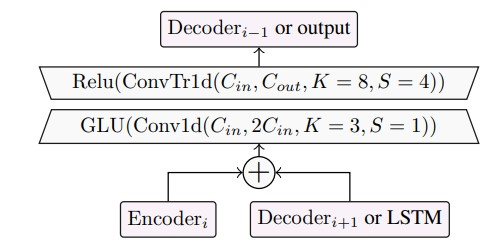

In [ ]:
# the first decoder
def outdec_conv1(num_filters,
                prev_out,
                k_s=3, 
                s_s=1, 
                is_last=False,
                padding='same',
                act=None):
  num_filters = num_filters
  this_conv1 = Conv1D(filters=num_filters*2, 
                      kernel_size=k_s,
                      padding=padding,
                      strides=s_s, 
                      activation=act)(prev_out)
  return this_conv1, num_filters

def outdec_conv2(num_filters,
                prev_conv,
                k_s=8,
                s_s=4,
                act='relu',
                is_last=False,
                padding='same'):
  num_filters = num_filters//2 if not is_last else 8
  this_conv2 = Conv1DTranspose(filters=num_filters,
                               kernel_size=k_s,
                               padding=padding,
                               strides=s_s,
                               activation=act)(prev_conv)
  return this_conv2, num_filters

def decoder_block(prev_out, num_filters, is_last=False):
  conv1, num_filters = outdec_conv1(is_last=is_last, 
                      num_filters=num_filters, 
                      prev_out=prev_out)
  
  this_glu = gokaf_glu()(inputs=conv1)

  conv2, num_filters = outdec_conv2(is_last=is_last,
                      num_filters=num_filters,
                      prev_conv=this_glu)
  return conv2, num_filters


## Whole Model Build

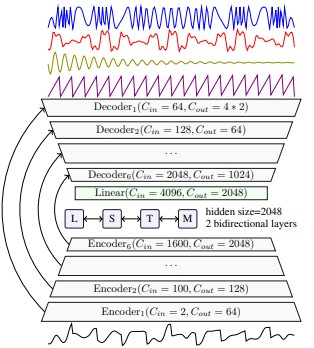

In [ ]:
def build_model():
  ### --- BUILD ENCODER --- ###
  # create the input layer, the first block, and a list for layer outputs
  input_layer = Input(shape=(None,2))
  first_block, num_filters = encoder_block(prev_out=input_layer, 
                                          num_filters=64, 
                                          is_first=True)
  enc_outputs = []
  enc_outputs.append(first_block)

  # declare that we are attaching new blocks to block1
  prev_block = first_block

  # for i in range 5, create a block, with the previous as input, then declare
  # (cont.) that the current is the previous block, repeat
  for i in range(5):
    this_block, num_filters = encoder_block(prev_out=prev_block,
                                            num_filters=num_filters)
    enc_outputs.append(this_block)
    prev_block = this_block

  ### --- BUILD LSTM AND LINEAR OUT --- ###
  # admittedly, this is the aspect of the model that I understand the least
  lstm = Bidirectional(LSTM(2048, return_sequences=True))(prev_block)
  lin_layer = Dense(2048)(lstm)
  lin_layer = gokaf_padcat()([lin_layer, enc_outputs[-1]])

  ### --- BUILD DECODER --- ###
  first_dec, num_filters = decoder_block(prev_out=lin_layer,
                                         num_filters=2048)
  
  # this process of concatenation is how we implement u-net skip connections
  first_dec = gokaf_padcat()([first_dec,enc_outputs[-2]])
  prev_block = first_dec

  for i in range(4,0,-1):
    this_block, num_filters = decoder_block(prev_out=prev_block,
                                            num_filters=num_filters)
    this_block = gokaf_padcat()([this_block,enc_outputs[i-1]])
    prev_block = this_block

  last_block, num_filters = decoder_block(prev_out=prev_block,
                                         num_filters=num_filters,
                                         is_last=True)

  # a linear transformation that, hopefully, gives us our stems!
  last_layer = Dense(8)(last_block)

  # this is a clumsy way of fixing padding issues
  last_layer = ZeroPadding1D(padding=(0,4))(last_layer)
  return tf.keras.Model(inputs=input_layer, outputs=last_layer)

# Data Pre-processing

## Imports

In [ ]:
# import the os module...install and import musdb
import os
!pip install musdb
import musdb
from google.colab import files

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# apologies...I don't have time to make this more generalisable. 
# what I'm doing here, however, should be pretty easy to adapt to a local kernel
# if you replace the next part where I set paths with pathways to your local
# drives, it should work just fine
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Paths

In [ ]:
# assign variables and PATH environmental variable for training data directories
data_dir = "/content/drive/MyDrive/training_data"
os.environ["MUSDB_PATH"] = data_dir
train_dir = os.path.join(data_dir,"train")
test_dir = os.path.join(data_dir,"test")
data_root = musdb.DB(root=data_dir)

In [ ]:
# set paths for training and testing datasets
train_data = musdb.DB(subsets="train")
test_data = musdb.DB(subsets="test")

## Set Creation

The below code:

- Defines a function that extracts main mixes and stems from each item in the data set
- Puts these mixes and stems into training and test sets

I'm using google colab, so I parallelise the process to take full of my their VMs...this process takes ages otherwise. But you can this original code if you don't want to use parallel processing:



```
# empty python lists to hold data while appending
train_mixes = []
train_drums = []
train_bass = []
train_other = []
train_vocals = []


# use our function to make lists of song components
for track in data_root:
    # grab a chunk from a random point in the song of a given length.
    # (cont.) we do 10 seconds, like the folks in the paper did
    track.chunk_duration = 10.0
    track.chunk_start = random.uniform(0, track.duration - track.chunk_duration)
    
    mix, drums, bass, other, vocals = set_creator(track)
    train_mixes.append(mix)
    train_drums.append(drums)
    train_bass.append(bass)
    train_other.append(other)
    train_vocals.append(vocals)
    
# convert those lists to numpy arrays
train_mixes = np.array(train_mixes)
train_drums = np.array(train_drums)
train_bass = np.array(train_bass)
train_other = np.array(train_other)
train_vocals = np.array(train_vocals)```



In [ ]:
from joblib import Parallel, delayed

# empty python lists to hold data while appending
train_mixes = []
train_drums = []
train_bass = []
train_other = []
train_vocals = []

# define a function that extracts sources and mixtures. pretty straightforward
def set_creator(given_track):
    mixture = given_track.audio.astype(np.float32)
    drums = given_track.targets["drums"].audio.astype(np.float32)
    bass = given_track.targets["bass"].audio.astype(np.float32)
    other = given_track.targets["other"].audio.astype(np.float32)
    vocals = given_track.targets["vocals"].audio.astype(np.float32)
    return mixture, drums, bass, other, vocals

# use our function to make lists of song components
def process_track(track):
  # grab a chunk from a random point in the song of a given length.
  # (cont.) we do 10 seconds, like the folks in the paper did
  track.chunk_duration = 10.0
  track.chunk_start = random.uniform(0, track.duration - track.chunk_duration)
  
  mix, drums, bass, other, vocals = set_creator(track)
  
  # Specify your expected shape here:
  expected_shape = (441000, 2)

  # Check if all arrays have the expected shape
  if (np.shape(mix) == expected_shape and
      np.shape(drums) == expected_shape and
      np.shape(bass) == expected_shape and
      np.shape(other) == expected_shape and
      np.shape(vocals) == expected_shape):
      return mix, drums, bass, other, vocals
  else:
      return None

# parallel process with our above function, then prune any invalid data points
results = Parallel(n_jobs=-1, verbose=10)(delayed(process_track)(track) for track in data_root)
results = [result for result in results if result is not None]

# get the lists
train_mixes, train_drums, train_bass, train_other, train_vocals = zip(*results)

# convert those lists to numpy arrays
train_mixes = np.array(train_mixes)
train_drums = np.array(train_drums)
train_bass = np.array(train_bass)
train_other = np.array(train_other)
train_vocals = np.array(train_vocals)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:   36.6s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   38.5s finished


In [ ]:
# designate our inputs, and stack the labels (actual stems) in a way which 
# (cont.) our models can process

x_train = train_mixes
y_train = np.stack([train_drums, train_bass, train_other, train_vocals], axis=-1).reshape(train_mixes.shape[0],train_mixes.shape[1],8)

# Training

## Model Build, Summary (Outline)

In [ ]:
test_model=build_model()
test_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 2)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, None, 64)     1088        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, None, 128)    8320        ['conv1d[0][0]']                 
                                                                                                  
 gokaf_glu (gokaf_glu)          (None, None, 64)     0           ['conv1d_1[0][0]']               
                                                                                              

# Model Training

## Compilation, Early Stopping

In [ ]:
# compile the model to prepare for training. We use the loss functions and
# (cont.) learning rate outlined in the paper
test_model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4),
                  loss='mean_absolute_error')

# outline an early stopping function for training...we go for a small delta and
# (cont.) aim at mean absolute error because we are dealing with audio floating
# (cont.) points...the differences are very, very minute
e_stop = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0.0001,
    patience=100,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
    start_from_epoch=0,
)

## Training / Fitting, Save

In [ ]:
# finally, train the model on our training set
history = test_model.fit(x_train, y_train,
                         epochs=360, batch_size=32,
                         callbacks=[e_stop])


# save the model 
test_model.save('test_model.h5')

Epoch 1/360
5/5 [==============================] - 61s 4s/step - loss: 0.0384
Epoch 2/360
5/5 [==============================] - 3s 514ms/step - loss: 0.0383
Epoch 3/360
5/5 [==============================] - 3s 631ms/step - loss: 0.0383
Epoch 4/360
5/5 [==============================] - 3s 515ms/step - loss: 0.0382
Epoch 5/360
5/5 [==============================] - 3s 632ms/step - loss: 0.0382
Epoch 6/360
5/5 [==============================] - 3s 516ms/step - loss: 0.0381
Epoch 7/360
5/5 [==============================] - 3s 632ms/step - loss: 0.0381
Epoch 8/360
5/5 [==============================] - 3s 520ms/step - loss: 0.0380
Epoch 9/360
5/5 [==============================] - 3s 518ms/step - loss: 0.0380
Epoch 10/360
5/5 [==============================] - 3s 631ms/step - loss: 0.0379
Epoch 11/360
5/5 [==============================] - 3s 519ms/step - loss: 0.0379
Epoch 12/360
5/5 [==============================] - 3s 630ms/step - loss: 0.0378
Epoch 13/360
5/5 [=====================

# Model Testing

While model output is not brilliantly clear, we can see that the model succeeds to some degree in seperating out audio.

## Imports

In [ ]:
import soundfile as sf
from IPython.display import Audio
from IPython.display import display

## Function Definitions

In [ ]:
# get a .wav (44.1Khz, stereo) and load it as a numpy array.
# transpose it so the shape matches model input expectations
def preprocess_wav(given_wav):
  track, sr = librosa.load(given_wav, sr=44100, mono=False)
  return track.T

## Testing


In [43]:
def show_preds(prediction):
  labels = ["drums","vocals","bass","other"]
  for i in range(4):
    output_file = f"train_test{labels[i]+str(np.random.randint(9999))}.wav"
    stereo_phrase = i*2
    print(labels[i])
    sf.write(f'{output_file}', prediction[0,:,stereo_phrase:stereo_phrase+2], 44100)
    display(Audio(output_file))

In [ ]:
prediction = test_model.predict(x_train[50][np.newaxis, ...])

1/1 [==============================] - 0s 51ms/step


In [ ]:
show_preds(prediction)

https://www.researchgate.net/publication/345316071_Rethinking_the_Design_of_Sequence-to-Sequence_Models_for_Efficient_Machine_Translation/figures?lo=1&utm_source=google&utm_medium=organic